In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

#1. 数据集清洗
#1.1 读取数据
data_home = 'E:\\machineLearning\\kaggle\\dataset\\'
save_home = 'E:\\machineLearning\\kaggle\\projectResult\\musicRecommend\\'
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home + 'train_triplets.txt',
                              sep='\t', header=None,
                              names=['user', 'song', 'play_count']) #有一部分是数据库文件
triplet_dataset.shape

(48373586, 3)

In [2]:
triplet_dataset.info()
triplet_dataset.head(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [3]:
#1.2 统计分析
#1.2.1 统计每一个用户的播放总量
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        user = line.split('\t')[0] #用户
        play_count = int(line.split('\t')[2]) #该用户的播放总量数据
        if user in output_dict:
            play_count += output_dict[user]
            output_dict.update({user: play_count})
        output_dict.update({user: play_count}) #判断结果字典中是否已有该用户
output_list = [{'user': k, 'play_count': v} for k, v in output_dict.items()] #将结果字典转换为列表形式
play_count_df = pd.DataFrame(output_list) #转换为DF格式
play_count_df = play_count_df.sort_values(by='play_count', ascending=False) #排序
play_count_df.to_csv(path_or_buf=save_home + 'user_playcount_df.csv',
                     index=False) #保存结果

In [4]:
#1.2.2 统计每一首歌的播放总量，如上
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        song = line.split('\t')[1]
        play_count = int(line.split('\t')[2])
        if song in output_dict:
            play_count += output_dict[song]
            output_dict.update({song: play_count})
        output_dict.update({song: play_count})
output_list = [{'song': k, 'play_count': v} for k, v in output_dict.items()]
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by='play_count', ascending=False)
song_count_df.to_csv(path_or_buf=save_home + 'song_playcount_df.csv',
                     index=False)

In [5]:
#1.2.3 展示统计结果
play_count_df = pd.read_csv(filepath_or_buffer=save_home + 'user_playcount_df.csv')
play_count_df.head(n=10)

,user,play_count
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
5,4ae01afa8f2430ea0704d502bc7b57fb52164882,6472
6,b7c24f770be6b802805ac0e2106624a517643c17,6150
7,113255a012b2affeab62607563d03fbdf31b08e7,5656
8,6d625c6557df84b60d90426c0116138b617b9449,5620
9,99ac3d883681e21ea68071019dba828ce76fe94d,5602


In [6]:
song_count_df = pd.read_csv(filepath_or_buffer=save_home + 'song_playcount_df.csv')
song_count_df.head(10)

,song,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880
5,SOAXGDH12A8C13F8A1,356533
6,SONYKOW12AB01849C9,292642
7,SOPUCYA12A8C13A694,274627
8,SOUFTBI12AB0183F65,268353
9,SOVDSJC12A58A7A271,244730


In [7]:
#1.3 选取目标集合
total_play_count = sum(song_count_df.play_count)
play_count_subset = play_count_df.head(n=100000)
song_count_subset = song_count_df.head(n=30000)
#前10万名用户的播放量占总体的比例
print((float(play_count_df.head(n=100000).play_count.sum()) / total_play_count)*100)
#前3万首歌曲的播放量占总体的比例
print((float(song_count_df.head(n=30000).play_count.sum()) / total_play_count)*100)

40.8807280500655
78.39315366645269


In [8]:
#1.4 原始数据集清洗
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home + 'train_triplets.txt',
                              sep='\t', header=None, names=['user', 'song', 'play_count'])#读取原始数据集

triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset)]
del(triplet_dataset) #只保留前10万用户
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub) #只保留前3万歌曲

triplet_dataset_sub_song.to_csv(path_or_buf=save_home + 'triplet_dataset_sub_song.csv', index=False) #保存过滤后的数据集
triplet_dataset_sub_song.shape

(10774558, 3)

In [9]:
#1.5 数据集整合
#读取每首歌曲的其他详细信息
conn = sqlite3.connect(data_home + 'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]
track_metadata_df_sub.to_csv(path_or_buf=save_home + 'track_metadata_df_sub.csv', index=False) #保存读取后的数据

In [10]:
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=save_home+'triplet_dataset_sub_song.csv', encoding="ISO-8859-1")
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=save_home+'track_metadata_df_sub.csv', encoding="ISO-8859-1")
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


In [11]:
#1.6 选择指定特征
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid']) #去掉无用
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id']) #去掉重复
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, 
                                           how='left', left_on='song', right_on='song_id') #整合该音乐信息数据和之前的播放数据
triplet_dataset_sub_song_merged.rename(columns={'play_count': 'listen_count'}, inplace=True) #改变列名
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work']) #去掉不需要指标
triplet_dataset_sub_song_merged.head(n=10)

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0
5,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,You're The One,If There Was A Way,Dwight Yoakam,1990
6,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986
7,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,S.O.S.,SOS,Jonas Brothers,2007
8,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1,The Invisible Man,The Invisible Man,Michael Cretu,1985
9,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8,American Idiot [feat. Green Day & The Cast Of ...,The Original Broadway Cast Recording 'American...,Green Day,0


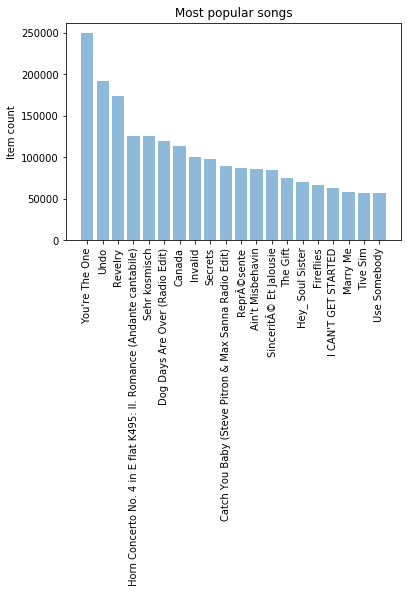

In [13]:
# 1.7 统计
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# 1.7.1 按歌曲名字来统计其播放量的总数
popular_songs = triplet_dataset_sub_song_merged[['title', 'listen_count']].groupby('title').sum().reset_index()
# 对结果进行排序
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)
# 绘图
objects = (list(popular_songs_top_20['title'])) # 转换成list格式方便画图
y_pos = np.arange(len(objects)) # 设置位置
performance = list(popular_songs_top_20['listen_count']) # 对应结果值
plt.bar(y_pos, performance, align='center', alpha=0.5) 
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
plt.show()

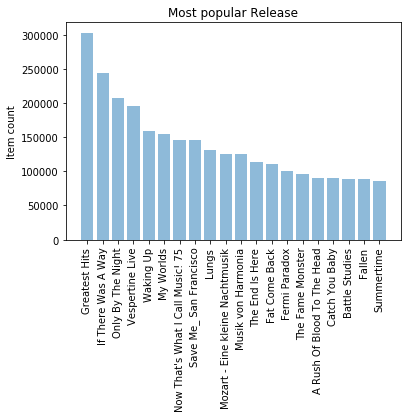

In [14]:
# 1.7.2 按专辑名字来统计播放总量
popular_release = triplet_dataset_sub_song_merged[['release', 'listen_count']].groupby('release').sum().reset_index()
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)
objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
plt.show()

In [15]:
# 1.7.3 用户播放的分布情况
user_song_count_distribution = (triplet_dataset_sub_song_merged[['user', 'title']].
                                groupby('user').count().reset_index().sort_values(by='title', ascending=False))
user_song_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

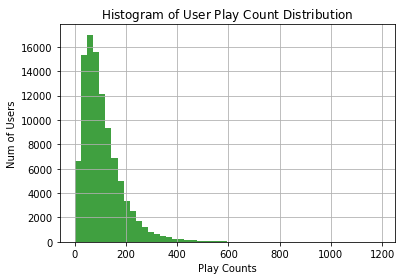

In [16]:
# 绘图展示
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)

In [17]:
# 2. 基于相似度的推荐系统
# 2.1 排行榜推荐
def create_popularity_recommendation(train_data, user_id, item_id):
    # 根据指定的特征来统计其播放情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    # 为了直观展示，我们用得分来表示其结果
    train_data_grouped.rename(columns={user_id: 'score'}, inplace=True)
    # 排行榜单需要排序
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending=[0, 1])
    # 加入一项排行等级，表示其推荐的优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
    # 返回指定个数的推荐结果
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')
recommendations.head(n=20)

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


In [18]:
# 3. 基于矩阵分解的推荐
# 3.1 使用SVD奇异矩阵分解，定义用户对歌曲打分值为 该用户播放该歌曲量/该用户总播放量
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user', 'listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count': 'total_listen_count'}, inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329


In [19]:
# 计算比例
triplet_dataset_sub_song_merged['fractional_play_count'] = (triplet_dataset_sub_song_merged['listen_count'] /
                                                            triplet_dataset_sub_song_merged['total_listen_count'])

# 3.2 制作简单的id索引，构建矩阵
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index': 'user_index'}, inplace=True)
song_codes.rename(columns={'index': 'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set, song_codes, how='left')
small_set = pd.merge(small_set, user_codes, how='left')
mat_candidate = small_set[['us_index_value', 'so_index_value', 'fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [20]:
# 3.3 SVD矩阵分解
import math as mt
from scipy.sparse.linalg import *
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

# 3.3.1 执行SVD，指定K值
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i, i] = mt.sqrt(s[i])
    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    return U, S, Vt
# 参数选择
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]
U, S, Vt = compute_svd(urm, K)

# 3.3.2 将小矩阵还原
def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S * Vt
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID, max_recommendation), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :] * rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [21]:
# 3.4 选取测试用户
uTest = [4,5,6,7,8,873,23]
# 对用户进行推荐
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
# 将结果按照得分值排序
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("推荐编号： {}， 推荐歌曲是： {} ，作者 {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value += 1

Recommendation for user with user id 4
推荐编号： 1， 推荐歌曲是： Fireflies ，作者 Charttraxx Karaoke
推荐编号： 2， 推荐歌曲是： Hey_ Soul Sister ，作者 Train
推荐编号： 3， 推荐歌曲是： OMG ，作者 Usher featuring will.i.am
推荐编号： 4， 推荐歌曲是： Lucky (Album Version) ，作者 Jason Mraz & Colbie Caillat
推荐编号： 5， 推荐歌曲是： Vanilla Twilight ，作者 Owl City
推荐编号： 6， 推荐歌曲是： Crumpshit ，作者 Philippe Rochard
推荐编号： 7， 推荐歌曲是： Billionaire [feat. Bruno Mars]  (Explicit Album Version) ，作者 Travie McCoy
推荐编号： 8， 推荐歌曲是： Love Story ，作者 Taylor Swift
推荐编号： 9， 推荐歌曲是： TULENLIEKKI ，作者 M.A. Numminen
推荐编号： 10， 推荐歌曲是： Use Somebody ，作者 Kings Of Leon
Recommendation for user with user id 5
推荐编号： 1， 推荐歌曲是： Sehr kosmisch ，作者 Harmonia
推荐编号： 2， 推荐歌曲是： Ain't Misbehavin ，作者 Sam Cooke
推荐编号： 3， 推荐歌曲是： Dog Days Are Over (Radio Edit) ，作者 Florence + The Machine
推荐编号： 4， 推荐歌曲是： Revelry ，作者 Kings Of Leon
推荐编号： 5， 推荐歌曲是： Undo ，作者 BjÃ¶rk
推荐编号： 6， 推荐歌曲是： Cosmic Love ，作者 Florence + The Machine
推荐编号： 7， 推荐歌曲是： Home ，作者 Edward Sharpe & The Magnetic Zeros
推荐编号： 8， 推荐歌曲是： You've Got The Love 